## Run trained models for qualitative analysis

In [5]:
import logging

logger = logging.getLogger()
logger.disabled = True

import os
from collections import Counter
from copy import deepcopy

from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from agent import DQNAgent
from humemai.utils import read_yaml
from humemai.policy import (
    answer_question,
    argmax,
    encode_observation,
    explore,
    manage_memory,
)

root_path = (
    f"trained-results/non-equal-object-probs/dqn/room_size=xl-different-prob/"
    f"capacity=48/2024-07-04 04:19:34.336511"
)


train_params_path = os.path.join(root_path, "train.yaml")
train_params = read_yaml(train_params_path)
train_params["default_root_dir"] = "training-results/TRASH"
train_params["semantic_decay_factor"] = 0.8
num_tests = 20

stats_interest = [
    {
        "mm": {"state": [], "attention": [], "q_value": [], "action": []},
        "explore": {"state": [], "attention": [], "q_value": [], "action": []},
        "hidden_state": [],
        "questions": [],
        "answers": [],
        "score": None,
    }
    for _ in range(num_tests)
]


def process_room_observations(
    agent: DQNAgent, observations_room: list
) -> tuple[list, list, list, list]:
    """Process room observations. This is used when training an exploration policy.

    Args:
        DQNAgent: agent
        observations_room: observations["room"] from the environment

    Returns:
        tuple[list, list, list]: states_all, attention_all, q_values_all, actions_all

    """
    states_all = []
    attention_all = []
    q_values_all = []
    actions_all = []

    for obs in observations_room:
        encode_observation(agent.memory_systems, obs)
        state = agent.memory_systems.return_as_a_dict_list()
        states_all.append(deepcopy(state))
        with torch.no_grad():
            lstm_out, attention = agent.lstm_mm(
                np.array([state]), agent.memory_types["mm"]
            )
            attention = attention.squeeze(0).sum(dim=0).tolist()
            q_values = agent.mlp_mm(lstm_out).detach().cpu().tolist()[0]

            action = argmax(q_values)

            manage_memory(
                memory_systems=agent.memory_systems,
                policy=agent.action2str["mm"][action],
                split_possessive=False,
            )

        attention_all.append(deepcopy(attention))
        q_values_all.append(deepcopy(q_values))
        actions_all.append(deepcopy(action))
    agent.memory_systems.semantic.decay()

    return states_all, attention_all, q_values_all, actions_all


def explore(agent: DQNAgent) -> tuple[list, list, list, list]:
    """Explore the environment using the exploration policy.

    Args:
        DQNAgent: agent

    Returns:
        tuple[dict, list, list]: state, attention, q_values, action

    """
    state = agent.get_deepcopied_memory_state()
    with torch.no_grad():
        lstm_out, attention = agent.lstm_explore(
            np.array([state]), agent.memory_types["explore"]
        )
        attention = attention.squeeze(0).sum(dim=0).tolist()
        q_values = agent.mlp_explore(lstm_out).detach().cpu().tolist()[0]
        action = argmax(q_values)

    return state, attention, q_values, action


def load_models(agent: DQNAgent, root_path: str) -> None:
    """Load models from a given root_path.

    Args:
        DQNAgent: agent
        root_path: root path

    """
    for checkpoint_path in glob(os.path.join(root_path, "*/*/*/*.pt")):
        if "mm" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_mm.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_mm.eval()
            for param in agent.lstm_mm.parameters():
                param.requires_grad = False
        elif "mm" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_mm.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_mm.eval()
            for param in agent.mlp_mm.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_explore.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_explore.eval()
            for param in agent.lstm_explore.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_explore.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_explore.eval()
            for param in agent.mlp_explore.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unknown checkpoint path")


for idx in tqdm(range(num_tests)):
    train_params["train_seed"] = idx
    train_params["test_seed"] = idx
    agent = DQNAgent(**train_params)
    load_models(agent, root_path)
    new_episode_starts = True
    score = 0
    while True:
        if new_episode_starts:
            agent.init_memory_systems()
            observations, info = agent.env.reset()
            done = False
            states_all, attention_all, q_values_all, actions_all = (
                process_room_observations(agent, observations["room"])
            )
            stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
            stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
            stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
            stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            new_episode_starts = False

        else:
            state, attention, q_values, action = explore(agent)
            stats_interest[idx]["explore"]["state"].append(deepcopy(state))
            stats_interest[idx]["explore"]["attention"].append(deepcopy(attention))
            stats_interest[idx]["explore"]["q_value"].append(deepcopy(q_values))
            stats_interest[idx]["explore"]["action"].append(deepcopy(action))

            answers = [
                answer_question(
                    agent.memory_systems,
                    agent.qa_function,
                    q,
                    split_possessive=False,
                )
                for q in observations["questions"]
            ]
            stats_interest[idx]["questions"].extend(deepcopy(observations["questions"]))
            stats_interest[idx]["answers"].extend(deepcopy(answers))

            stats_interest[idx]["hidden_state"].append(
                deepcopy(agent.env.unwrapped.hidden_global_states_all)
            )
            action_pair = (answers, agent.action2str["explore"][action])
            (
                observations,
                reward,
                done,
                truncated,
                info,
            ) = agent.env.step(action_pair)
            done = done or truncated

            if not done:
                states_all, attention_all, q_values_all, actions_all = (
                    process_room_observations(agent, observations["room"])
                )
                stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
                stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
                stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
                stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            score += reward

        if done:
            break
    stats_interest[idx]["score"] = score

    agent.remove_results_from_disk()


for idx in range(num_tests):
    print(
        idx,
        ": ",
        stats_interest[idx]["score"],
        "\t",
        Counter(stats_interest[idx]["mm"]["action"]),
        Counter(stats_interest[idx]["explore"]["action"]),
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Running on cpu


  5%|▌         | 1/20 [00:04<01:31,  4.83s/it]

Running on cpu


 10%|█         | 2/20 [00:10<01:31,  5.08s/it]

Running on cpu


 15%|█▌        | 3/20 [00:15<01:27,  5.16s/it]

Running on cpu


 20%|██        | 4/20 [00:19<01:17,  4.85s/it]

Running on cpu


 25%|██▌       | 5/20 [00:24<01:11,  4.78s/it]

Running on cpu


 30%|███       | 6/20 [00:29<01:08,  4.92s/it]

Running on cpu


 35%|███▌      | 7/20 [00:34<01:03,  4.88s/it]

Running on cpu


 40%|████      | 8/20 [00:39<00:58,  4.85s/it]

Running on cpu


 45%|████▌     | 9/20 [00:43<00:50,  4.57s/it]

Running on cpu


 50%|█████     | 10/20 [00:47<00:45,  4.59s/it]

Running on cpu


 55%|█████▌    | 11/20 [00:52<00:42,  4.71s/it]

Running on cpu


 60%|██████    | 12/20 [00:58<00:39,  4.92s/it]

Running on cpu


 65%|██████▌   | 13/20 [01:02<00:33,  4.73s/it]

Running on cpu


 70%|███████   | 14/20 [01:06<00:27,  4.59s/it]

Running on cpu


 75%|███████▌  | 15/20 [01:11<00:23,  4.76s/it]

Running on cpu


 80%|████████  | 16/20 [01:16<00:18,  4.63s/it]

Running on cpu


 85%|████████▌ | 17/20 [01:20<00:13,  4.63s/it]

Running on cpu


 90%|█████████ | 18/20 [01:30<00:12,  6.09s/it]

Running on cpu


 95%|█████████▌| 19/20 [01:39<00:07,  7.12s/it]

Running on cpu


100%|██████████| 20/20 [01:44<00:00,  5.24s/it]

0 :  316 	 Counter({1: 511, 0: 39}) Counter({2: 95, 1: 5})
1 :  181 	 Counter({1: 628, 0: 41}) Counter({1: 95, 2: 5})
2 :  216 	 Counter({1: 697, 0: 41}) Counter({1: 95, 2: 5})
3 :  217 	 Counter({1: 502, 0: 41}) Counter({1: 95, 2: 5})
4 :  327 	 Counter({1: 493, 0: 39}) Counter({2: 95, 1: 5})
5 :  200 	 Counter({1: 581, 0: 38}) Counter({2: 96, 1: 4})
6 :  289 	 Counter({1: 489, 0: 39}) Counter({2: 95, 1: 5})
7 :  320 	 Counter({1: 498, 0: 40}) Counter({2: 95, 1: 5})
8 :  209 	 Counter({1: 499, 0: 40}) Counter({1: 96, 2: 4})
9 :  190 	 Counter({1: 521, 0: 37}) Counter({2: 96, 1: 4})
10 :  161 	 Counter({1: 657, 0: 42}) Counter({1: 95, 2: 5})
11 :  361 	 Counter({1: 525, 0: 39}) Counter({2: 95, 1: 5})
12 :  343 	 Counter({1: 529, 0: 39}) Counter({2: 95, 1: 5})
13 :  277 	 Counter({1: 467, 0: 39}) Counter({2: 95, 1: 5})
14 :  283 	 Counter({1: 472, 0: 39}) Counter({2: 95, 1: 5})
15 :  300 	 Counter({1: 484, 0: 41}) Counter({2: 95, 1: 5})
16 :  227 	 Counter({1: 549, 0: 40}) Counter({1: 9

In [6]:
idx_of_interest = 11

In [7]:
last_hidden_state = [foo for foo in stats_interest[idx_of_interest]["hidden_state"]][-1]
last_hidden_state

[[['room_000', 'north', 'wall', 0],
  ['room_000', 'east', 'room_001', 0],
  ['room_000', 'south', 'room_004', 0],
  ['room_000', 'west', 'wall', 0],
  ['room_001', 'north', 'wall', 0],
  ['room_001', 'east', 'wall', 0],
  ['room_001', 'south', 'room_005', 0],
  ['room_001', 'west', 'room_000', 0],
  ['room_002', 'north', 'wall', 0],
  ['room_002', 'east', 'room_003', 0],
  ['room_002', 'south', 'room_008', 0],
  ['room_002', 'west', 'wall', 0],
  ['room_003', 'north', 'wall', 0],
  ['room_003', 'east', 'wall', 0],
  ['room_003', 'south', 'room_009', 0],
  ['room_003', 'west', 'room_002', 0],
  ['room_004', 'north', 'room_000', 0],
  ['room_004', 'east', 'room_005', 0],
  ['room_004', 'south', 'wall', 0],
  ['room_004', 'west', 'wall', 0],
  ['room_005', 'north', 'room_001', 0],
  ['room_005', 'east', 'room_006', 0],
  ['room_005', 'south', 'wall', 0],
  ['room_005', 'west', 'room_004', 0],
  ['room_006', 'north', 'wall', 0],
  ['room_006', 'east', 'room_007', 0],
  ['room_006', 'south

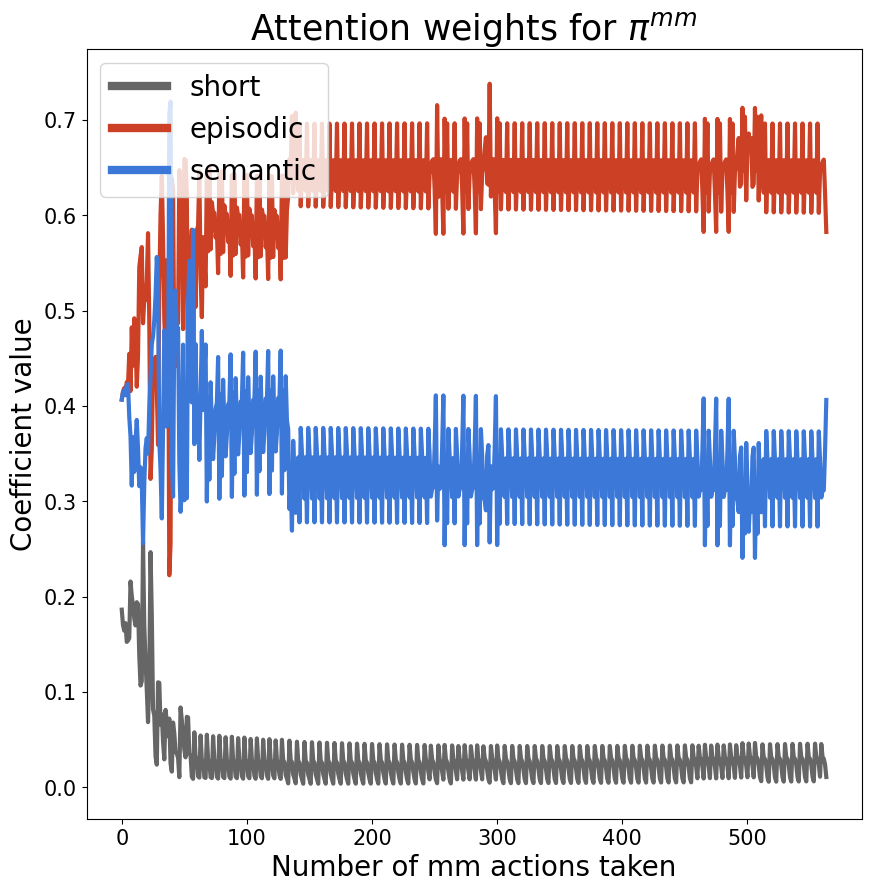

In [8]:
colors = ["#666666ff", "#cc4125ff", "#3c78d8ff"]  # short, episodic, semantic

plt.figure(figsize=(10, 10))
for i in range(len(agent.memory_types["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["attention"]],
        label=agent.memory_types["mm"][i],
        color=colors[i],
        linewidth=3.0,
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=20)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{mm}$", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("attention_weights_mm.pdf")
plt.show()

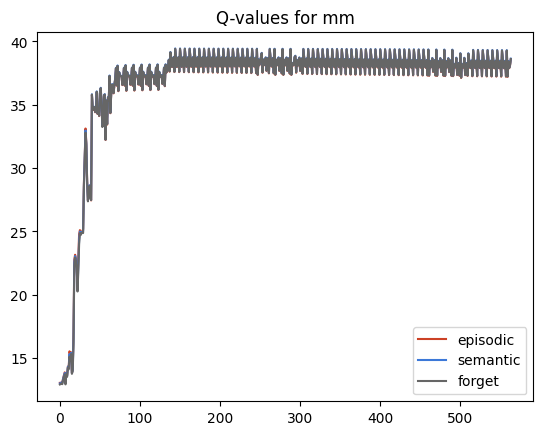

In [9]:
colors = ["#cc4125ff", "#3c78d8ff", "#666666ff"]  # episodic, semantic, forget
for i in range(len(agent.action2str["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["q_value"]],
        label=agent.action2str["mm"][i],
        color=colors[i],
    )

plt.legend(loc="best")
plt.title("Q-values for mm");

In [10]:
[
    (idx, agent.action2str["mm"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["action"])
]

[(0, 'episodic'),
 (1, 'episodic'),
 (2, 'episodic'),
 (3, 'episodic'),
 (4, 'episodic'),
 (5, 'episodic'),
 (6, 'episodic'),
 (7, 'episodic'),
 (8, 'episodic'),
 (9, 'episodic'),
 (10, 'episodic'),
 (11, 'episodic'),
 (12, 'episodic'),
 (13, 'episodic'),
 (14, 'episodic'),
 (15, 'episodic'),
 (16, 'episodic'),
 (17, 'episodic'),
 (18, 'episodic'),
 (19, 'episodic'),
 (20, 'episodic'),
 (21, 'episodic'),
 (22, 'episodic'),
 (23, 'episodic'),
 (24, 'episodic'),
 (25, 'episodic'),
 (26, 'episodic'),
 (27, 'episodic'),
 (28, 'episodic'),
 (29, 'episodic'),
 (30, 'episodic'),
 (31, 'episodic'),
 (32, 'episodic'),
 (33, 'episodic'),
 (34, 'episodic'),
 (35, 'episodic'),
 (36, 'episodic'),
 (37, 'semantic'),
 (38, 'episodic'),
 (39, 'semantic'),
 (40, 'semantic'),
 (41, 'semantic'),
 (42, 'semantic'),
 (43, 'semantic'),
 (44, 'semantic'),
 (45, 'semantic'),
 (46, 'semantic'),
 (47, 'semantic'),
 (48, 'semantic'),
 (49, 'semantic'),
 (50, 'semantic'),
 (51, 'semantic'),
 (52, 'semantic'),
 (5

In [11]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["state"])
]

[(0,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'north', 'wall', 0]]}),
 (1,
  1,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0]],
   'semantic': [],
   'short': [['room_000', 'east', 'room_001', 0]]}),
 (2,
  2,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0]],
   'semantic': [],
   'short': [['room_000', 'south', 'room_004', 0]]}),
 (3,
  3,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0]],
   'semantic': [],
   'short': [['room_000', 'west', 'wall', 0]]}),
 (4,
  4,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0],
    ['room_000', 'west', 'wall', 0]],
   'semantic': [],
   'short': [['agent', 'atlocation', 'room_000', 0]]}),
 (5,
  5,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001',

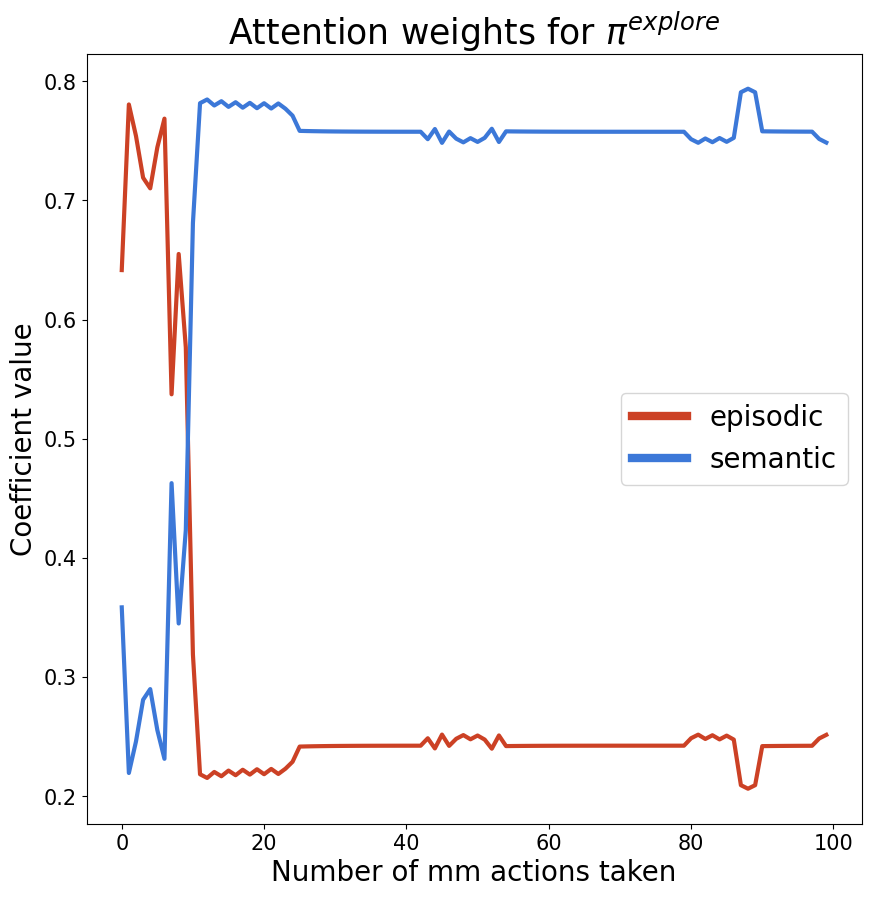

In [12]:
colors = ["#cc4125ff", "#3c78d8ff"]  # episodic, semantic

plt.figure(figsize=(10, 10))

for i in range(len(agent.memory_types["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["attention"]],
        label=agent.memory_types["explore"][i],
        linewidth=3.0,
        color=colors[i],
    )

# Create the legend
leg = plt.legend(loc="best", fontsize=20)

# Change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)

plt.title("Attention weights for $\pi^{explore}$", fontsize=25)
plt.xlabel("Number of mm actions taken", fontsize=20)
plt.ylabel("Coefficient value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("attention_weights_explore.pdf")
plt.show()

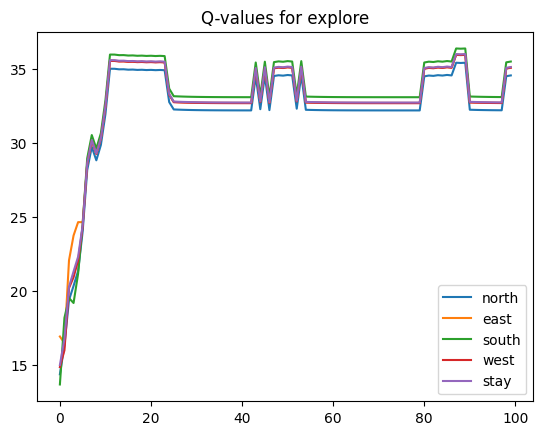

In [13]:
for i in range(len(agent.action2str["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["q_value"]],
        label=agent.action2str["explore"][i],
    )

plt.legend(loc="best")
plt.title("Q-values for explore");

In [14]:
[
    (idx, agent.action2str["explore"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["action"])
]

[(0, 'east'),
 (1, 'south'),
 (2, 'east'),
 (3, 'east'),
 (4, 'east'),
 (5, 'east'),
 (6, 'south'),
 (7, 'south'),
 (8, 'south'),
 (9, 'south'),
 (10, 'south'),
 (11, 'south'),
 (12, 'south'),
 (13, 'south'),
 (14, 'south'),
 (15, 'south'),
 (16, 'south'),
 (17, 'south'),
 (18, 'south'),
 (19, 'south'),
 (20, 'south'),
 (21, 'south'),
 (22, 'south'),
 (23, 'south'),
 (24, 'south'),
 (25, 'south'),
 (26, 'south'),
 (27, 'south'),
 (28, 'south'),
 (29, 'south'),
 (30, 'south'),
 (31, 'south'),
 (32, 'south'),
 (33, 'south'),
 (34, 'south'),
 (35, 'south'),
 (36, 'south'),
 (37, 'south'),
 (38, 'south'),
 (39, 'south'),
 (40, 'south'),
 (41, 'south'),
 (42, 'south'),
 (43, 'south'),
 (44, 'south'),
 (45, 'south'),
 (46, 'south'),
 (47, 'south'),
 (48, 'south'),
 (49, 'south'),
 (50, 'south'),
 (51, 'south'),
 (52, 'south'),
 (53, 'south'),
 (54, 'south'),
 (55, 'south'),
 (56, 'south'),
 (57, 'south'),
 (58, 'south'),
 (59, 'south'),
 (60, 'south'),
 (61, 'south'),
 (62, 'south'),
 (63, '

In [15]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["state"])
]

[(0,
  7,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0],
    ['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['dep_007', 'atlocation', 'room_000', 0],
    ['dep_001', 'atlocation', 'room_000', 0]],
   'semantic': [],
   'short': []}),
 (1,
  12,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_000', 'east', 'room_001', 0],
    ['room_000', 'south', 'room_004', 0],
    ['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['dep_007', 'atlocation', 'room_000', 0],
    ['dep_001', 'atlocation', 'room_000', 0],
    ['room_001', 'north', 'wall', 1],
    ['room_001', 'east', 'wall', 1],
    ['room_001', 'south', 'room_005', 1],
    ['room_001', 'west', 'room_000', 1],
    ['agent', 'atlocation', 'room_001', 1]],
   'semantic': [],
   'short': []}),
 (2,
  17,
  0,
  {'episodic': [['room_000', 'north', 'wall', 0],
    ['room_00

In [16]:
Counter([str(foo[:-1]) for foo in stats_interest[idx_of_interest]["questions"]])

Counter({"['sta_002', 'atlocation', '?']": 143,
         "['ind_001', 'atlocation', '?']": 132,
         "['sta_006', 'atlocation', '?']": 109,
         "['dep_002', 'atlocation', '?']": 99,
         "['sta_005', 'atlocation', '?']": 92,
         "['dep_005', 'atlocation', '?']": 90,
         "['sta_004', 'atlocation', '?']": 64,
         "['ind_002', 'atlocation', '?']": 57,
         "['ind_007', 'atlocation', '?']": 33,
         "['sta_003', 'atlocation', '?']": 30,
         "['ind_004', 'atlocation', '?']": 27,
         "['dep_003', 'atlocation', '?']": 26,
         "['dep_007', 'atlocation', '?']": 24,
         "['ind_005', 'atlocation', '?']": 22,
         "['dep_001', 'atlocation', '?']": 15,
         "['ind_006', 'atlocation', '?']": 10,
         "['ind_000', 'atlocation', '?']": 9,
         "['sta_001', 'atlocation', '?']": 7,
         "['dep_006', 'atlocation', '?']": 4,
         "['sta_000', 'atlocation', '?']": 4,
         "['dep_000', 'atlocation', '?']": 3})

In [17]:
from collections import Counter

Counter([str(foo) for foo in stats_interest[idx_of_interest]["answers"]])

Counter({'none': 609,
         'room_008': 134,
         'room_027': 108,
         'room_021': 81,
         'room_006': 62,
         'room_007': 6})